In [2]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
#from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [3]:
load_dotenv()

True

In [5]:
#openai_model=ChatOpenAI(model="gpt-4")

In [6]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [7]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003485617, 'queue_time': 0.046172468999999994, 'total_time': 0.061667435}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_2834edf0f4', 'finish_reason': 'stop', 'logprobs': None}, id='run-3a41e4bb-a5fa-454d-bd4c-a9b1d837c7cb-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [8]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [9]:
state={"num1":1, "num2":2}

In [10]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [11]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [12]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [13]:
model_with_tool=groq_model.bind_tools([transfer_to_multiplication_expert])

In [14]:
ai_message=model_with_tool.invoke("hi how are you?")

In [15]:
ai_message.tool_calls

[]

In [16]:
ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [17]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_7py2',
  'type': 'tool_call'}]

In [18]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = groq_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [19]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [20]:
graph=StateGraph(MessagesState)

In [21]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [22]:
graph.add_edge(START, "additional_expert")

In [23]:
app=graph.compile()

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [25]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='b6bf304c-b2f6-4906-82ce-ef0f060434bb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g6b2', 'function': {'arguments': '{"num1":8,"num2":12}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 377, 'prompt_tokens': 159, 'total_tokens': 536, 'completion_time': 1.3709090910000001, 'prompt_time': 0.01762808, 'queue_time': 2.023752698, 'total_time': 1.388537171}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6a21dd80-c620-4ecc-b83f-4deacf0ba1df-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {'num1': 8, 'num2': 12}, 'id': 'call_g6b2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 377, 'total_tokens': 536}),
  ToolMes

In [46]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [47]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_fU9aR641xB2AR76HdZK1W6eL)
 Call ID: call_fU9aR641xB2AR76HdZK1W6eL
  Args:
    numbers: [8, 12]
    operation: multiply
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================

The result is 96.




In [27]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [28]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [29]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [30]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [31]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

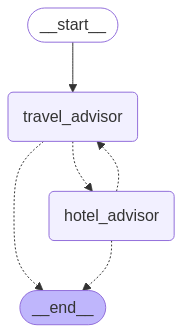

In [32]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [33]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='5a52bbea-085d-4571-b932-5e9205c4014e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qv96', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 479, 'prompt_tokens': 355, 'total_tokens': 834, 'completion_time': 1.741818182, 'prompt_time': 0.023070809, 'queue_time': -1.003114829, 'total_time': 1.7648889909999999}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_2834edf0f4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ebc57864-ee18-4e47-8e0f-3726f27f0cdd-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_qv96', 'type': 'tool_call'}], usage_metadata={'input_tokens': 355, 'output_tokens': 479, 't

In [34]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

To assist you with your travel plans from Mumbai to California, I'll first need to know which specific city in California you're interested in visiting (e.g., Los Angeles, San Francisco, etc.). This will help me provide more tailored recommendations for your trip.




In [37]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Mumbai to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_f585)
 Call ID: call_f585
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

Sure! For your travel from Mumbai to California, here are some recommendations for flights and hotels:

### **Flight Recommendations:**
1. **Airlines:**  
   - **Emirates:** Known for excellent service and comfortable long-haul flights.  
   - **Qatar Airways:** Offers a great in-flight experience with convenient layovers in Doha.  
   - **Singapore Airlines:** A top choice for comfort and quality service.  
   - **Air India:** A good option if you prefer a non-stop flight or shorter layovers.  

2. **Route Suggestions:**  
   - Mumbai (BOM) to 